# Direct Optimization of Discrete Variational Autoencoder 

### Generative model on the MNIST dataset, where the latent space is N one-hot vectors of size K


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torchvision

import math
import numpy as np
import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#### hyper parameters

In [2]:
params = {'num_epochs': 10,
            'print_model': True,
            'batch_size': 100,
            'learning_rate': 0.001,
            'gumbels' : 5,
            'N_K': (6,2),
            'eps_0':1.0,
            'anneal_rate':1e-5,
            'min_eps':0.1,
            'save_images':False,
            'print_result':False}
 
random.seed(59)
torch.manual_seed(59)
is_cuda = torch.cuda.is_available()

#### utils functions

In [3]:
def denorm(x): #from range [-1,1] to [0,1]
    out = (x + 1) / 2
    return out.clamp(0, 1)

def norm(x): #from range [0,1] to [-1,1]
    out = 2*x - 1
    return out.clamp(-1, 1)


def get_data_loaders(params):
    bsize= params['batch_size']
    transform = transforms.ToTensor() 
    train_dataset = datasets.MNIST(root='./data',
                         train=True,
                         transform=transform,
                         download=True)

    test_dataset = datasets.MNIST(root='./data',
                     train=False,
                     transform=transform,
                     download=True)
    # Data loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=bsize, 
                                              shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size=bsize, 
                                              shuffle=False)
    return train_loader,test_loader

def to_var(x):
    if is_cuda:
        x = x.cuda()
    return x

def kl_multinomial(phi_x):
    K = phi_x.size(-1)
    q_z = F.softmax(phi_x,dim =1)    
    log_q_z = torch.log(q_z+1e-20)    
    kl_tmp = q_z * (log_q_z - math.log(1.0/K))
    return kl_tmp.sum()

#### VAE model 

In [4]:

class Encoder(nn.Module):
    def __init__(self, image_size=784, h_dim=(400,200), N=6,K=6,M=20):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size,h_dim[0]),
            nn.ReLU(),
            nn.Linear(h_dim[0],h_dim[1]),
            nn.ReLU(),
            nn.Linear(h_dim[1],N*K))
        
        self.N = N
        self.K = K
        self.M = M     
    def forward(self, x):
        phi_x = self.encoder(x).view(-1,self.K)
        z,phi_x_g = self.gumbel_perturbation(phi_x)
        return z,phi_x_g,phi_x 

    def sample_gumbel(self,shape, eps=1e-20):
        #Sample from Gumbel(0, 1)
        U = torch.rand(shape).float()
        return -torch.log(eps - torch.log(U + eps))
    
    def gumbel_perturbation(self,phi_x, eps=1e-10):
        M,K,N = self.M,self.K,self.N               
        if M != 0:
            phi_x = phi_x.repeat(M,1)
        
        shape = phi_x.size()
        assert len(shape) == 2
        gumbel_noise = to_var(self.sample_gumbel(shape, eps=eps))
        phi_x_gamma = phi_x + gumbel_noise

        if M != 0:
            phi_x_gamma = phi_x_gamma.view(M,-1,N,K)
        phi_x_gamma = phi_x_gamma.view(-1,K)
        # hard:
        _, k = phi_x_gamma.data.max(-1)
        if is_cuda:
            z = torch.cuda.FloatTensor(*shape).zero_().scatter_(-1, k.view(-1, 1), 1.0)
        else:
            z = torch.FloatTensor(*shape).zero_().scatter_(-1, k.view(-1, 1), 1.0)
        z_phi_gamma = to_var(z)
        return z_phi_gamma,phi_x_gamma

class Decoder(nn.Module):
    def __init__(self, image_size=784, h_dim=(400,200), N=6,K=6,M=3):
        super(Decoder, self).__init__()       
        self.decoder = nn.Sequential(
            nn.Linear(N*K,h_dim[0]),
            nn.ReLU(),
            nn.Linear(h_dim[0],h_dim[1]),
            nn.ReLU(),
            nn.Linear(h_dim[1], image_size))

        self.N = N
        self.K = K
        self.M = M
        
    def forward(self, y):
        out = self.decoder(y.view(-1,self.N*self.K))
        if self.M != 0:
            out = out.view(self.M,-1,out.size(1)).mean(dim=0)
        return out
    
    def theta(self, y):
        out = self.decoder(y.view(-1,self.N*self.K))
        return out

In [5]:
class Direct_VAE:
    def __init__(self,params):

        self.N,self.K  = params['N_K'] 
        self.M = params['gumbels']
        self.encoder = Encoder(N=self.N,K=self.K,M=self.M)
        self.decoder = Decoder(N=self.N,K=self.K,M=self.M)
        self.eps = params['eps_0']
        self.annealing_rate = params['anneal_rate']

        self.params = params
        
        if params['print_model']:
            print 'encoder: ',self.encoder
            print 'decoder: ',self.decoder
            params['print_model'] = False
        if torch.cuda.is_available():
            self.encoder.cuda()
            self.decoder.cuda()
            
        lr = params['learning_rate']
        self.optimizer_e = torch.optim.Adam(self.encoder.parameters(), lr=lr)
        self.optimizer_d = torch.optim.Adam(self.decoder.parameters(), lr=lr)
        self.bce_loss = nn.BCEWithLogitsLoss(size_average=False, reduce=False)
        self.training_iter = 0


    def train(self,train_loader):    
        kl_sum,bce_sum = 0,0
        eps_0,ANNEAL_RATE,min_eps = params['eps_0'],params['anneal_rate'],params['min_eps']        
        for i, (im, _) in enumerate(train_loader):
            images = to_var(im.view(im.size(0), -1)).round()
            labels = images if self.M == 0 else images.repeat(self.M,1)
            # forward
            z_hard,phi_x_g,phi_x = self.encoder(images)
            out = self.decoder(z_hard)

            # backward
            gradients = self.compute_encoder_gradients(z_hard,phi_x_g,labels,self.eps)
            encoder_loss = torch.sum(to_var(gradients)*phi_x_g)             
            decoder_loss  = self.bce_loss(out,images).sum()
            kl = kl_multinomial(phi_x)
            
            encoder_loss += kl
            self.optimizer_e.zero_grad()
            self.optimizer_d.zero_grad()

            decoder_loss.backward()
            encoder_loss.backward()

            self.optimizer_d.step()
            self.optimizer_e.step()
            
            bce_sum += (decoder_loss+kl)/(im.size(0))
            if self.training_iter % 500 == 0:
                a = eps_0*math.exp(-ANNEAL_RATE*self.training_iter)
                if a > min_eps:
                    self.eps = a
                else:
                    self.eps=min_eps

            self.training_iter += 1
        nll_bce = (bce_sum.item())/len(train_loader)
        return nll_bce

    def evaluate(self,test_loader):
        self.encoder.eval()
        self.decoder.eval()
        bce_sum =0
        kl_div = 0
        for images, labels in test_loader:        
            images = to_var(images.view(images.size(0), -1)).round()
            hards,_,phi_x = self.encoder(images)
            out = self.decoder(hards)
  
            decoder_loss = self.bce_loss(out,images).sum()
            kl = kl_multinomial(phi_x)
            bce_sum += (decoder_loss+kl)/images.size(0)

        self.encoder.train()
        self.decoder.train()
        nll_bce = bce_sum.item()/len(test_loader)
        return nll_bce

    def compute_encoder_gradients(self,z_hard,phi_x_g,ground_truth,epsilon=1.0):
        N = self.N
        K = self.K
        soft_copy = phi_x_g.data
        hard_copy = z_hard.data.view(-1,N,K)
        self.decoder.eval()
        losses = to_var(torch.zeros(hard_copy.size(0), K*N))
        l = 0
        for n in range(N):
            a_clone = hard_copy.clone()
            idx = n*torch.ones(hard_copy.size(0),1,hard_copy.size(2)).long()
            if is_cuda:
                idx = idx.cuda()                
            a_clone.scatter_(1,idx, 0)

            for k in range(K):
                clone2 = a_clone.clone()
                clone2[:,n,k]=1
                out = self.decoder.theta(to_var(clone2).view(-1,K))                
                total_loss_batchX784 = self.bce_loss(out,ground_truth) 
                    
                losses[:,l] = total_loss_batchX784.sum(dim = 1)
                l +=1

        hard_copy = hard_copy.view(-1,K)
        losses = epsilon*losses.view(-1,K).data
        soft_copy = soft_copy - losses
        shape = soft_copy.size()
        _, k = soft_copy.max(-1)
        if is_cuda:
            change = torch.cuda.FloatTensor(*shape).zero_().scatter_(-1, k.view(-1, 1),1.0) 
        else:
            change = torch.FloatTensor(*shape).zero_().scatter_(-1, k.view(-1, 1),1.0) 
        gradients = hard_copy - change
        self.decoder.train()
        gradients = gradients*(1.0/epsilon)
        return gradients

In [6]:
def training_procedure(params):

    train_loader,valid_loader = get_data_loaders(params)
    N,K = params['N_K']
    direct_vae = Direct_VAE(params)
    
    best_state_dicts = None
    print 'hyper parameters: ' ,params

    train_results,test_results = [],[]
    best_nll = 1000
    print_res = params['print_result']
    for epoch in range(params['num_epochs']):
        nll = direct_vae.train(train_loader)
        train_results.append(nll)
        if print_res:
            print " ------ Epoch[{}/{}] ------ ".format(epoch+1,  params['num_epochs'])
            print ("Train: NLL :{:.2f}".format(nll))

        nll  = direct_vae.evaluate(valid_loader) 
        test_results.append(nll)
        if print_res:     
            print ("Test: NLL:{:.2f}".format(nll))            
        if nll <best_nll:
            best_nll = nll
            best_state_dicts = (direct_vae.encoder.state_dict(),direct_vae.decoder.state_dict())

    return train_results,test_results,best_nll,best_state_dicts

#### Note that there are K ^ N different combinations of the latent space. Obviously, we can't optimize over such large space, so we optimize each N_i separately (total of N * K evaluations of the decoder). 


In [ ]:
def show_plots(list_a,list_b):
        plt.clf()
        epochs = range(len(list_a))
        plt.plot(epochs,list_a)
        plt.plot(epochs,list_b)
        plt.ylabel('NLL')
        plt.xlabel('epoch')
        plt.legend(['(6,2)','(1,64)'], loc='upper right')

        plt.show()

In [ ]:
params['N_K']= (3,2)
results1 = training_procedure(params)
params['N_K']= (1,8)
results2 = training_procedure(params)

In [ ]:
params['N_K']= (4,2)
results3 = training_procedure(params)
params['N_K']= (1,16)
results4 = training_procedure(params)

In [ ]:
params['N_K']= (5,2)
results5 = training_procedure(params)
params['N_K']= (1,32)
results6 = training_procedure(params)

In [ ]:
params['N_K']= (6,2)
results7 = training_procedure(params)
params['N_K']= (1,64)
results8 = training_procedure(params)

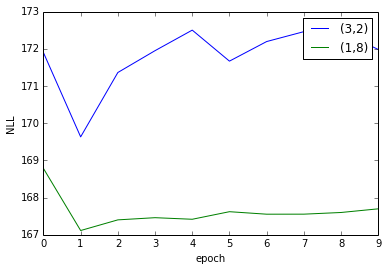

In [9]:
a = results1[1]
b = results2[1]
show_plots(a,b)

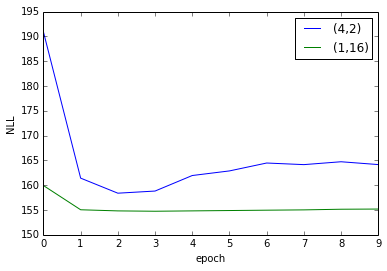

In [16]:
a = results3[1]
b = results4[1]
show_plots(a,b)

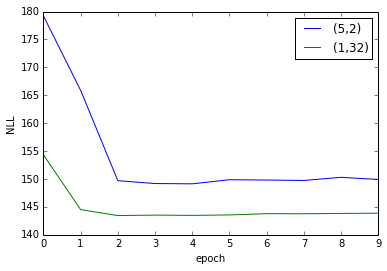

In [15]:
a = results5[1]
b = results6[1]
show_plots(a,b)

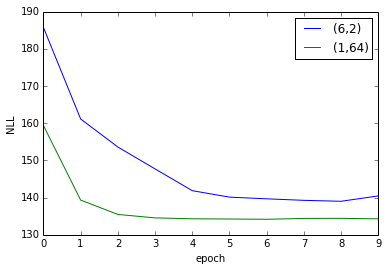

In [18]:
a = results7[1]
b = results8[1]
show_plots(a,b)